In [ ]:
## Vivendo case Vivendo is a fast food chain in Brazil with over 200 outlets.
## Customers often claim compensation from the company for food poisoning.
## The legal team processes these claims. The legal team has offices in four locations.
## The legal team wants to improve how long it takes to reply to customers and close claims.
## The head of the legal department wants a report on how each location differs in the time it
## takes to close claims.
!pip install --upgrade pandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df=pd.read_csv("food_claims_2212.csv")
df.head()


,claim_id,time_to_close,claim_amount,amount_paid,location,individuals_on_claim,linked_cases,cause
0,1,317,R$ 74474.55,51231.37,RECIFE,15,False,unknown
1,2,195,R$ 52137.83,42111.30,FORTALEZA,12,True,unknown
2,3,183,R$ 24447.2,23986.30,SAO LUIS,10,True,meat
3,4,186,R$ 29006.28,27942.72,FORTALEZA,11,False,meat
4,5,138,R$ 19520.6,16251.06,RECIFE,11,False,vegetable


In [ ]:
df.shape

(2000, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   claim_id              2000 non-null   int64  
 1   time_to_close         2000 non-null   int64  
 2   claim_amount          2000 non-null   object 
 3   amount_paid           1964 non-null   float64
 4   location              2000 non-null   object 
 5   individuals_on_claim  2000 non-null   int64  
 6   linked_cases          1974 non-null   object 
 7   cause                 2000 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 125.1+ KB


In [ ]:
## Missing values - amount_paid (change missing values to median) ,linked_cases (change missing values to false)
## changing dtypes - time_to close in days ,claim_amount (object to float)and dropping currency symbol,
## checking unique for claim_id .removing duplicates
## checking for outliers in claim_amount,amount_paid.



In [ ]:
data_df=df.copy()
data_df[data_df['amount_paid'].isnull()]['amount_paid']=data_df['amount_paid'].median



<ipython-input-64-d0a1f9468149>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[data_df['amount_paid'].isnull()]['amount_paid']=data_df['amount_paid'].median


In [ ]:
data_df=data_df[~data_df['linked_cases'].isna()]


In [ ]:
data_df['claim_amount']=data_df['claim_amount'].astype("str")
#data_df[data_df['claim_amount'].isna()]
data_df['claim_amount']=data_df['claim_amount'].str.replace("R$", "")

In [ ]:
data_df['claim_amount']=data_df['claim_amount'].astype(float)
data_df.drop_duplicates('claim_id',inplace=True)


In [ ]:
data_df['cause'].unique()
## issue with capital vegetable and meat

data_df['cause']=data_df['cause'].str.strip().str.lower()
data_df['cause']=data_df['cause'].apply( lambda x:"vegetable" if x=="vegetables" else x )

data_df['cause'].unique()

array(['unknown', 'meat', 'vegetable'], dtype=object)

<Axes: xlabel='location'>

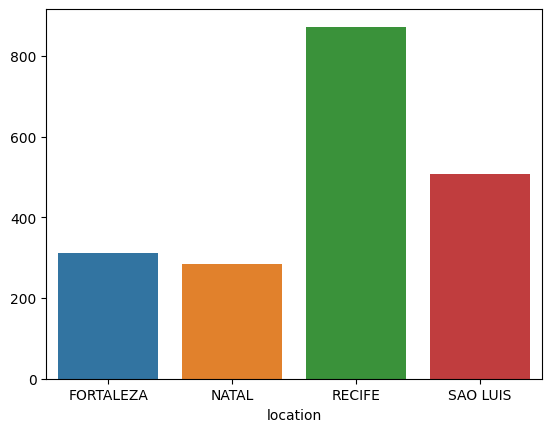

In [ ]:

sns.barplot(data=data_df,x=data_df.groupby('location')['claim_id'].count().index,y=data_df.groupby('location')['claim_id'].count().values)

<Axes: xlabel='time_to_close', ylabel='Count'>

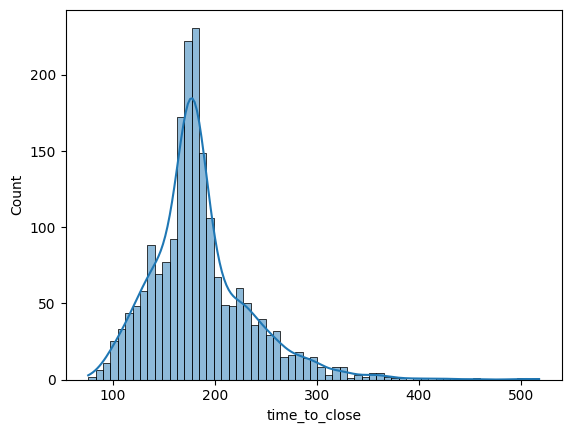

In [ ]:
sns.histplot(data=data_df,x='time_to_close',kde=True)

<Axes: xlabel='location', ylabel='time_to_close'>

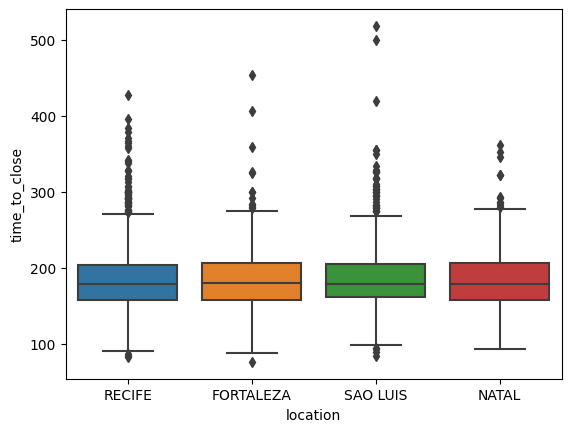

In [ ]:
sns.boxplot(x=data_df['location'],y=data_df['time_to_close'])